# RFM Analysis

In [20]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

df = pd.read_csv("data/cleaned_online_retail_II.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="%Y-%m-%d %H:%M:%S")

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [21]:
# Set analysis date as one day after the last invoice
analyse_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

In [22]:
# Calculate RFM metrics
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (analyse_date - x.max()).days, # Recency
    'Invoice': 'nunique', # Frequency
    'TotalPrice': 'sum' # Monetary
}).reset_index()

rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346,529,11,372.86
1,12347,2,8,4671.93
2,12348,75,5,1659.40
3,12349,19,3,3498.94
4,12350,310,1,294.40


In [23]:
# Calculate RFM scores by ranking each metric
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine scores into a single RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346,529,11,372.86,1,5,2,152
1,12347,2,8,4671.93,5,4,5,545
2,12348,75,5,1659.40,3,4,4,344
3,12349,19,3,3498.94,5,3,5,535
4,12350,310,1,294.40,2,1,2,212


In [24]:
# Segment customers based on RFM score
def segment_maker(score):
    if score == "555":
        return "Best Customers"
    
    elif score[1] == "5" and score[2] == "5":
        return "Loyal Big Spenders"

    elif score[0] == "5" and score[1] == "5":
        return "Loyal & Recent"

    elif score[0] == "5":
        return "Recent Customer"

    elif score[1] == "5":
        return "Loyal Customer"

    elif score[2] == "5":
        return "Big Spender"

    elif score == "111":
        return "At Risk"

    elif score[0] == "1":
        return "Lost Customer"

    elif score[1] in ["3", "4"] and score[2] in ["3", "4"]:
        return "Promising Customers"

    else:
        return "Regular Customer"
    
rfm['Segment'] = rfm['RFM_Score'].apply(segment_maker)
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346,529,11,372.86,1,5,2,152,Loyal Customer
1,12347,2,8,4671.93,5,4,5,545,Recent Customer
2,12348,75,5,1659.40,3,4,4,344,Promising Customers
3,12349,19,3,3498.94,5,3,5,535,Recent Customer
4,12350,310,1,294.40,2,1,2,212,Regular Customer


In [25]:
display(rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}))

Recency  Frequency      Monetary      
                           mean       mean          mean count
Segment                                                       
At Risk              569.292208   1.000000    144.591948   308
Best Customers         7.819533  27.726115  13334.131006   471
Big Spender          138.514151   5.745283   4465.082745   212
Lost Customer        534.817958   1.955720    586.233213   813
Loyal & Recent         8.800000  10.789474   2044.207474    95
Loyal Big Spenders    84.099526  15.990521   7081.619633   422
Loyal Customer       114.011429  10.982857   1923.738629   175
Promising Customers  144.300813   4.524842   1319.621510  1107
Recent Customer       10.055646   3.968903   1274.125092   611
Regular Customer     187.848125   1.693750    417.014583  1600

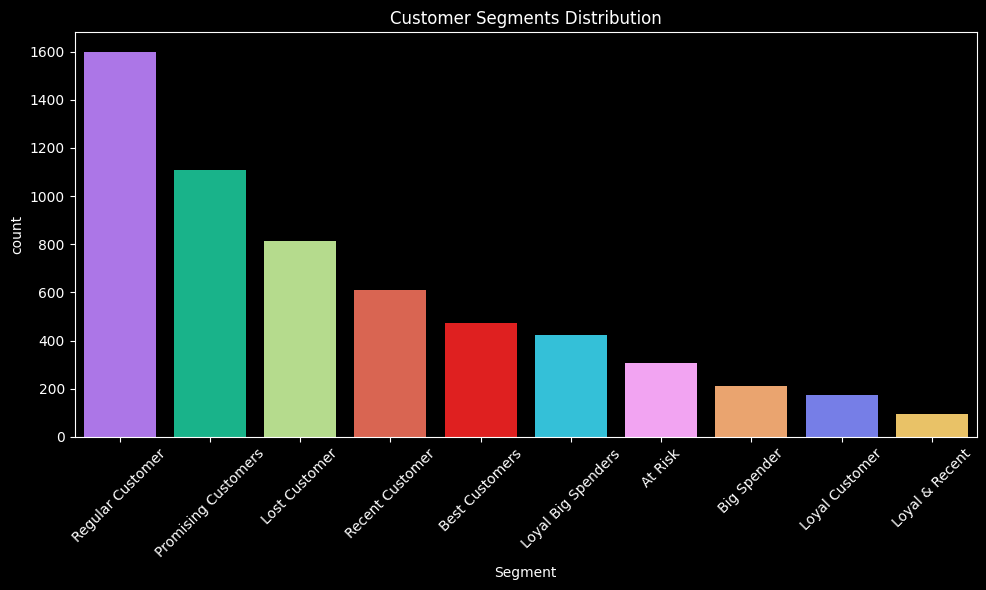

In [26]:
# Define the color palette for segments
segment_palette = {
    'Best Customers': "#FF0000",
    'Loyal Big Spenders': '#19d3f3',
    'Loyal & Recent': '#FECB52',
    'Recent Customer': '#EF553B',
    'Loyal Customer': '#636efa',
    'Big Spender': '#FFA15A',
    'At Risk': '#FF97FF',
    'Lost Customer': '#B6E880',
    'Promising Customers': '#00cc96',
    'Regular Customer': '#ab63fa'
}

# Create the count plot
plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x='Segment', hue='Segment', order=rfm['Segment'].value_counts().index, palette=segment_palette, legend=False)
plt.xticks(rotation=45)
plt.title("Customer Segments Distribution")
plt.tight_layout()
plt.show()


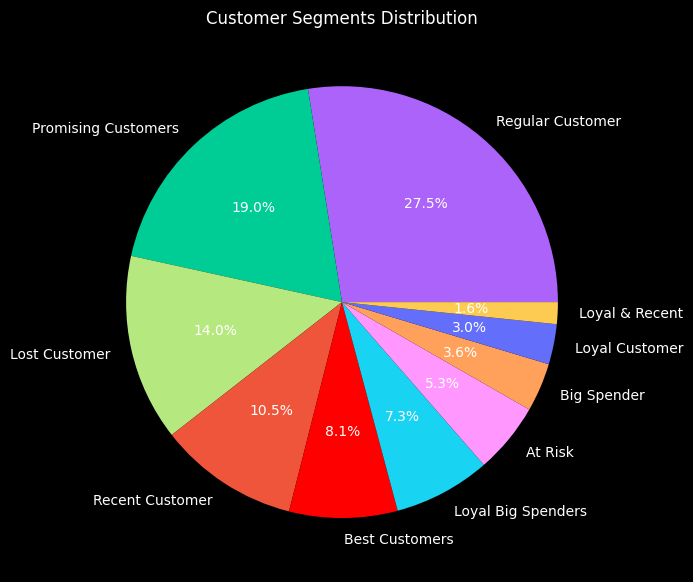

In [27]:
# Right: Segment distribution pie chart
fig, ax = plt.subplots(figsize=(7, 7))
rfm['Segment'].value_counts().plot.pie(
	ax=ax,
	autopct='%1.1f%%',
	colors=[segment_palette[s] for s in rfm['Segment'].value_counts().index]
)
ax.set_title('Customer Segments Distribution')
ax.set_ylabel('')

plt.tight_layout()
plt.show()

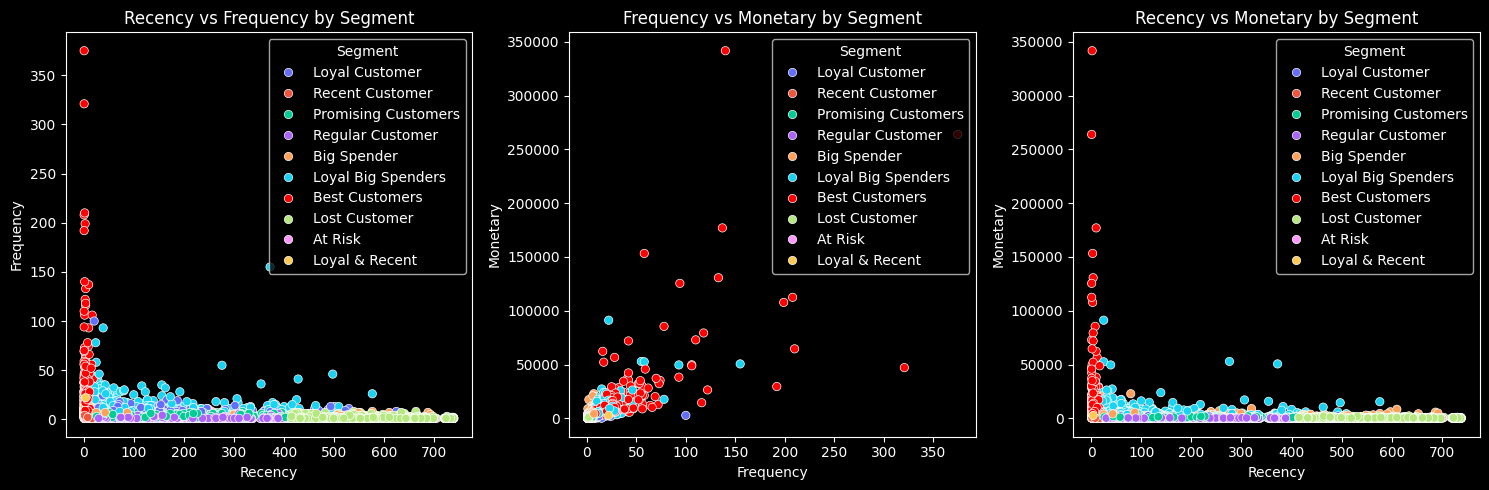

In [28]:
plt.figure(figsize=(15, 5))

# Recency vs Frequency
plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette=segment_palette)
plt.title('Recency vs Frequency by Segment')

# Frequency vs Monetary
plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette=segment_palette)
plt.title('Frequency vs Monetary by Segment')

# Recency vs Monetary
plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette=segment_palette)
plt.title('Recency vs Monetary by Segment')

plt.tight_layout()
plt.show()

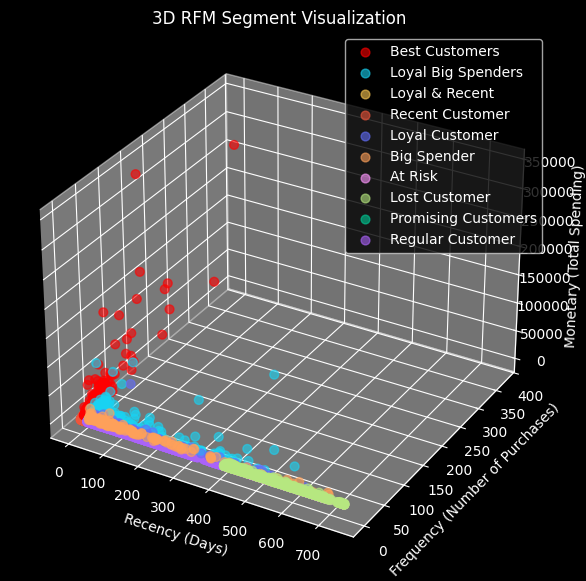

In [29]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

for segment, color in segment_palette.items():
    segment_data = rfm[rfm['Segment'] == segment]
    ax.scatter(
        segment_data['Recency'],
        segment_data['Frequency'],
        segment_data['Monetary'],
        c=color,
        label=segment,
        alpha=0.6,
        s=40
    )

ax.set_xlabel('Recency (Days)')
ax.set_ylabel('Frequency (Number of Purchases)')
ax.set_zlabel('Monetary (Total Spending)')
ax.set_title('3D RFM Segment Visualization')
ax.legend()
plt.show()


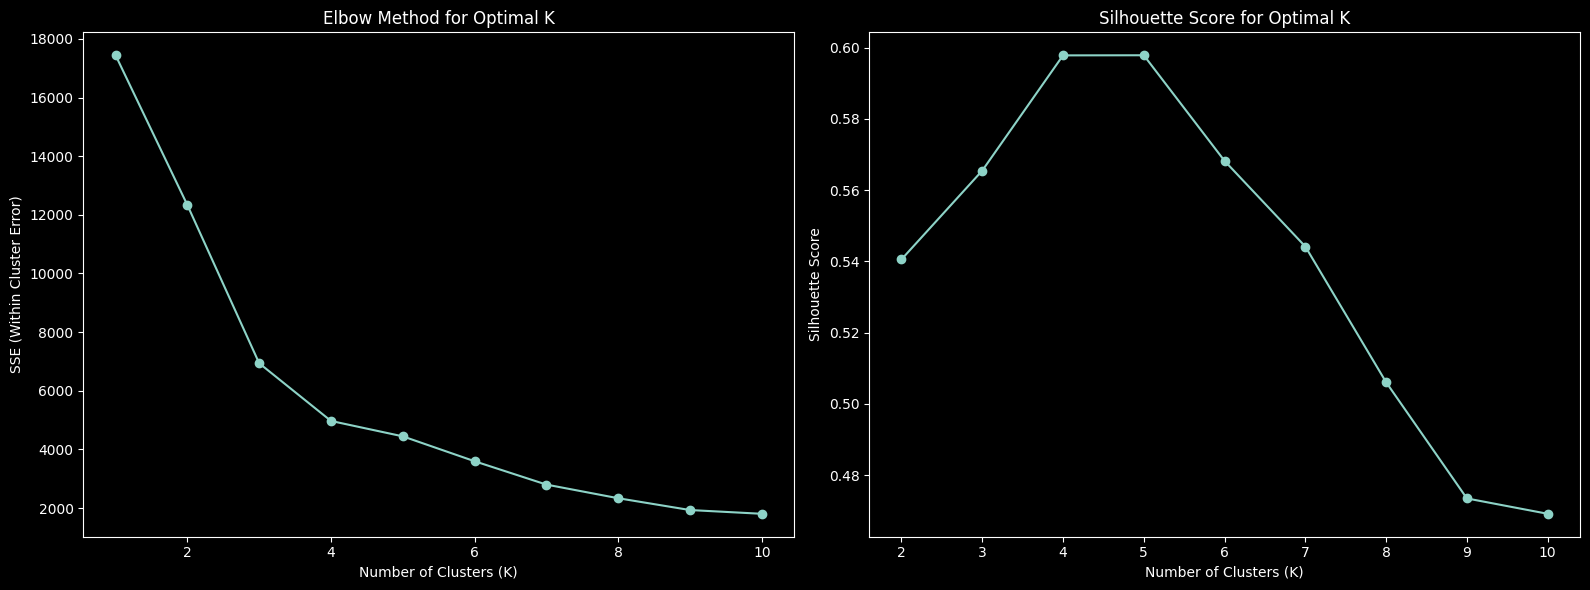

In [30]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

sil_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    sil_scores.append(score)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot Elbow Method
ax[0].plot(list(sse.keys()), list(sse.values()), marker='o')
ax[0].set_xlabel('Number of Clusters (K)')
ax[0].set_ylabel('SSE (Within Cluster Error)')
ax[0].set_title('Elbow Method for Optimal K')

# Plot Silhouette Score
ax[1].plot(range(2, 11), sil_scores, marker='o')
ax[1].set_xlabel('Number of Clusters (K)')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Score for Optimal K')

plt.tight_layout()
plt.show()


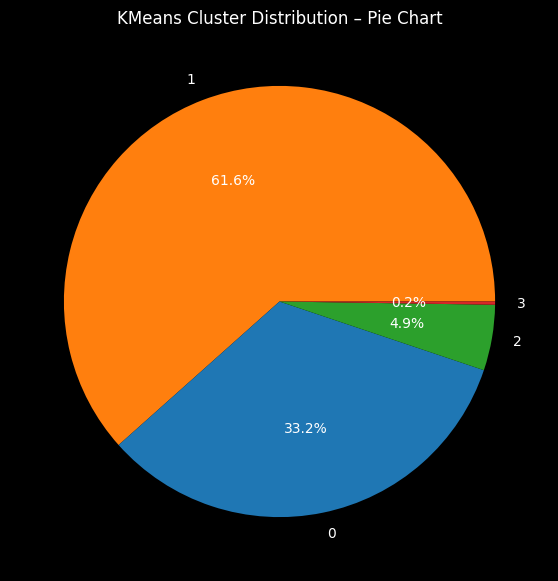

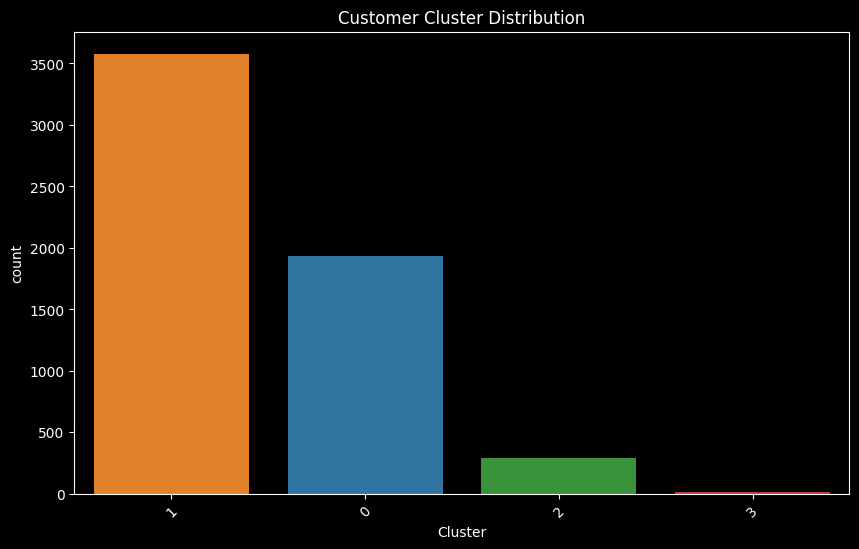

In [ ]:
# Apply KMeans with optimal_k
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(rfm_scaled)
rfm['Cluster'] = kmeans.labels_

# Pie chart
pie_colors = sns.color_palette('tab10', optimal_k)
rfm['Cluster'].value_counts().plot.pie(
    autopct='%1.1f%%',
    figsize=(7, 7),
    colors=[pie_colors[i] for i in rfm['Cluster'].value_counts().index]
)
plt.title('KMeans Cluster Distribution – Pie Chart')
plt.ylabel('')
plt.show()

# Count plot
plt.figure(figsize=(10, 6))
sns.countplot(
    data=rfm,
    x='Cluster',
    order=rfm['Cluster'].value_counts().index,
    hue='Cluster',
    palette='tab10',
    legend=False
)
plt.xticks(rotation=45)
plt.title("Customer Cluster Distribution")
plt.show()


Recency   Frequency       Monetary      
               mean        mean           mean count
Cluster                                             
0        465.575272    2.171754     645.514870  1933
1         72.218654    5.520525    1881.916390  3581
2         24.262238   33.555944   15490.300955   286
3         29.000000  175.000000  125485.606429    14

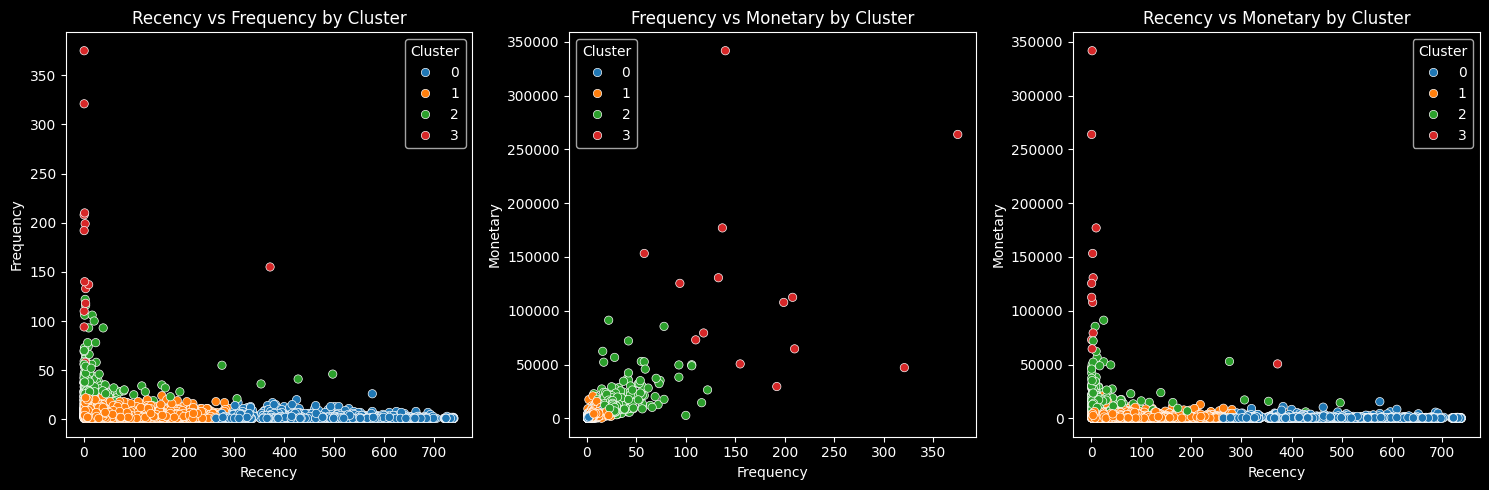

In [32]:
# Analyze clusters
cluster_analysis = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
})

display(cluster_analysis)

# Visualization
plt.figure(figsize=(15, 5))

# Recency vs Frequency
plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='tab10')
plt.title('Recency vs Frequency by Cluster')

# Frequency vs Monetary
plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='tab10')
plt.title('Frequency vs Monetary by Cluster')

# Recency vs Monetary
plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='tab10')
plt.title('Recency vs Monetary by Cluster')

plt.tight_layout()
plt.show()

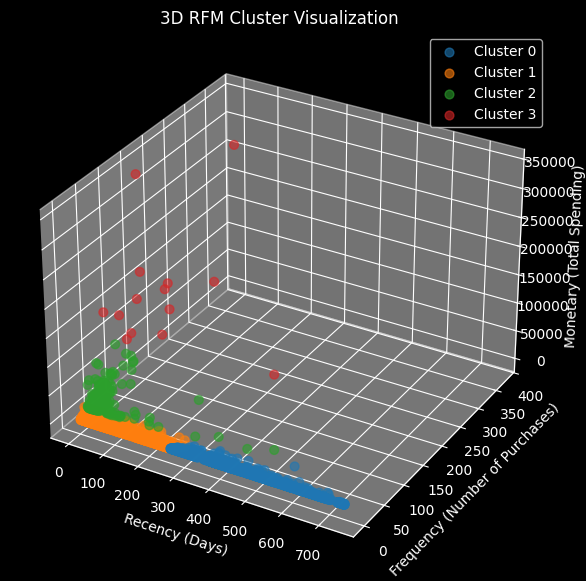

In [33]:
# 3D visualization of clusters
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette('tab10', n_colors=optimal_k)

for cluster in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == cluster]
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'],
               c=[colors[cluster]], label=f'Cluster {cluster}', alpha=0.6, s=40)

ax.set_xlabel('Recency (Days)')
ax.set_ylabel('Frequency (Number of Purchases)')
ax.set_zlabel('Monetary (Total Spending)')
ax.set_title('3D RFM Cluster Visualization')
ax.legend()
plt.show()


In [34]:
persona_map = {
    0: 'At-Risk & Lost',
    1: 'Loyal & Valuable',
    2: 'Champions',
    3: 'Whales / B2B'
}

# Add a new 'Persona' column to the rfm DataFrame
rfm['Persona'] = rfm['Cluster'].map(persona_map)

rfm.head()

# Show the distribution of personas
persona_counts = rfm['Persona'].value_counts()
print("Persona Distribution: \n")
print(persona_counts)

# Analyze average RFM values for each persona
persona_analysis = rfm.groupby('Persona')[['Recency', 'Frequency', 'Monetary']].mean().sort_values(by="Monetary", ascending=False)
print("\nAverage RFM Values by Persona:")
display(persona_analysis)

Persona Distribution: 

Persona
Loyal & Valuable    3581
At-Risk & Lost      1933
Champions            286
Whales / B2B          14
Name: count, dtype: int64

Average RFM Values by Persona:


,Recency,Frequency,Monetary
Persona,,,
Whales / B2B,29.000000,175.000000,125485.606429
Champions,24.262238,33.555944,15490.300955
Loyal & Valuable,72.218654,5.520525,1881.916390
At-Risk & Lost,465.575272,2.171754,645.514870


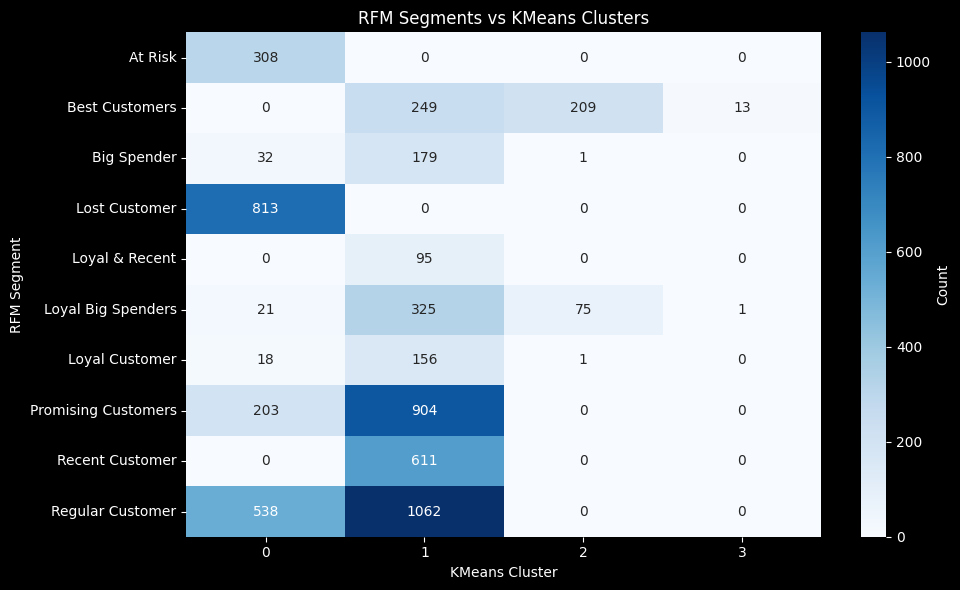

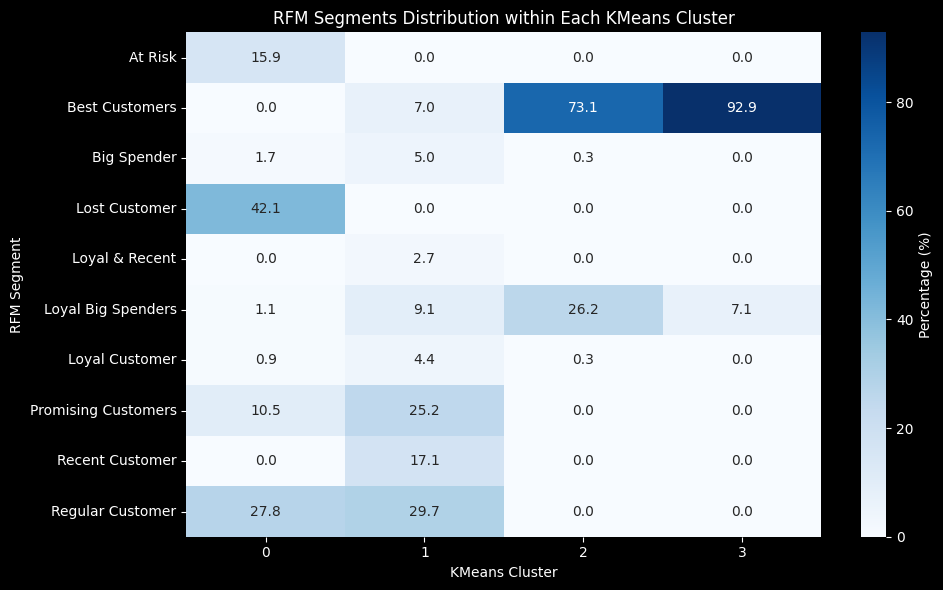

In [35]:
# Create a cross-tabulation between Segment and Cluster
crosstab = pd.crosstab(rfm['Segment'], rfm['Cluster'])

# Visualize the cross-tabulation as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('RFM Segments vs KMeans Clusters')
plt.xlabel('KMeans Cluster')
plt.ylabel('RFM Segment')
plt.tight_layout()
plt.show()

# Normalize by cluster (columns) to see segment distribution within each cluster
crosstab_normalized = pd.crosstab(rfm['Segment'], rfm['Cluster'], normalize='columns') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_normalized, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': 'Percentage (%)'})
plt.title('RFM Segments Distribution within Each KMeans Cluster')
plt.xlabel('KMeans Cluster')
plt.ylabel('RFM Segment')
plt.tight_layout()
plt.show()

In [36]:
# Perform Chi-square test to check independence between Segment and Cluster
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"\nChi-square test results:")
print(f"Chi2 statistic: {chi2:.2f}")
print(f"P-value: {p:.2f}") # < 0.05 indicates significant association
print("Expected frequencies table:")
display(pd.DataFrame(expected, index=crosstab.index, columns=crosstab.columns))


Chi-square test results:
Chi2 statistic: 5124.00
P-value: 0.00
Expected frequencies table:


Cluster,0,1,2,3
Segment,,,,
At Risk,102.401789,189.705538,15.151015,0.741658
Best Customers,156.594943,290.101651,23.169247,1.134159
Big Spender,70.484348,130.576539,10.428621,0.510492
Lost Customer,270.300826,500.748710,39.992776,1.957688
Loyal & Recent,31.584967,58.513072,4.673203,0.228758
Loyal Big Spenders,140.303750,259.921225,20.758858,1.016168
Loyal Customer,58.182835,107.787238,8.608531,0.421397
Promising Customers,368.047988,681.831269,54.455108,2.665635
Recent Customer,203.141211,376.331441,30.056072,1.471276


In [37]:
rfm.to_csv("data/rfm_analysis.csv", index=False)